In [2]:
import warnings

warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 0
import SEACells

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Peaks data
from scipy.io import mmread

%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

sc.set_figure_params(figsize=(10,10),dpi=120)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# ATAC Preprocessing from ArchR

In [125]:
# ATAC PREPROCESSING ACCORDING TO:
# https://github.com/dpeerlab/SEACells/blob/main/notebooks/ArchR/ArchR-preprocessing.ipynb
data_dir = '../results/ArchR/multiome10x_mouse/export/'

In [126]:
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [127]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:3094816-3095316,chr1,3094816,3095316,501,*,142.0470,0.922,0.729,2,C10._.Rep1,Xkr4,119416,Distal,120565,uc007afg.1,0.4271,1,0
chr1:3119745-3120245,chr1,3119745,3120245,501,*,8.4234,0.923,0.694,2,C5._.Rep2,Xkr4,94487,Distal,95636,uc007afg.1,0.3812,2,0
chr1:3121251-3121751,chr1,3121251,3121751,501,*,12.8192,0.599,0.212,2,C6._.Rep1,Xkr4,92981,Distal,94130,uc007afg.1,0.4411,3,0
chr1:3371495-3371995,chr1,3371495,3371995,501,*,16.6912,0.631,0.246,2,C4._.Rep1,Xkr4,157263,Intronic,156112,uc007afg.1,0.3972,4,0
chr1:3399685-3400185,chr1,3399685,3400185,501,*,8.4234,0.923,0.694,2,C5._.Rep2,Xkr4,185453,Intronic,184302,uc007afg.1,0.4112,5,0


In [131]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

/tmp/ipykernel_6329/1812160205.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(counts.T)


In [133]:
ad.X = ad.X.tocsr()
ad.raw = ad.copy()
ad

AnnData object with n_obs × n_vars = 4376 × 122247
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

In [134]:
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

In [135]:
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values
ad

AnnData object with n_obs × n_vars = 4376 × 122247
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    obsm: 'X_svd'

In [136]:
# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

In [137]:
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values
ad

AnnData object with n_obs × n_vars = 4376 × 122247
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'GeneScores'

In [138]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

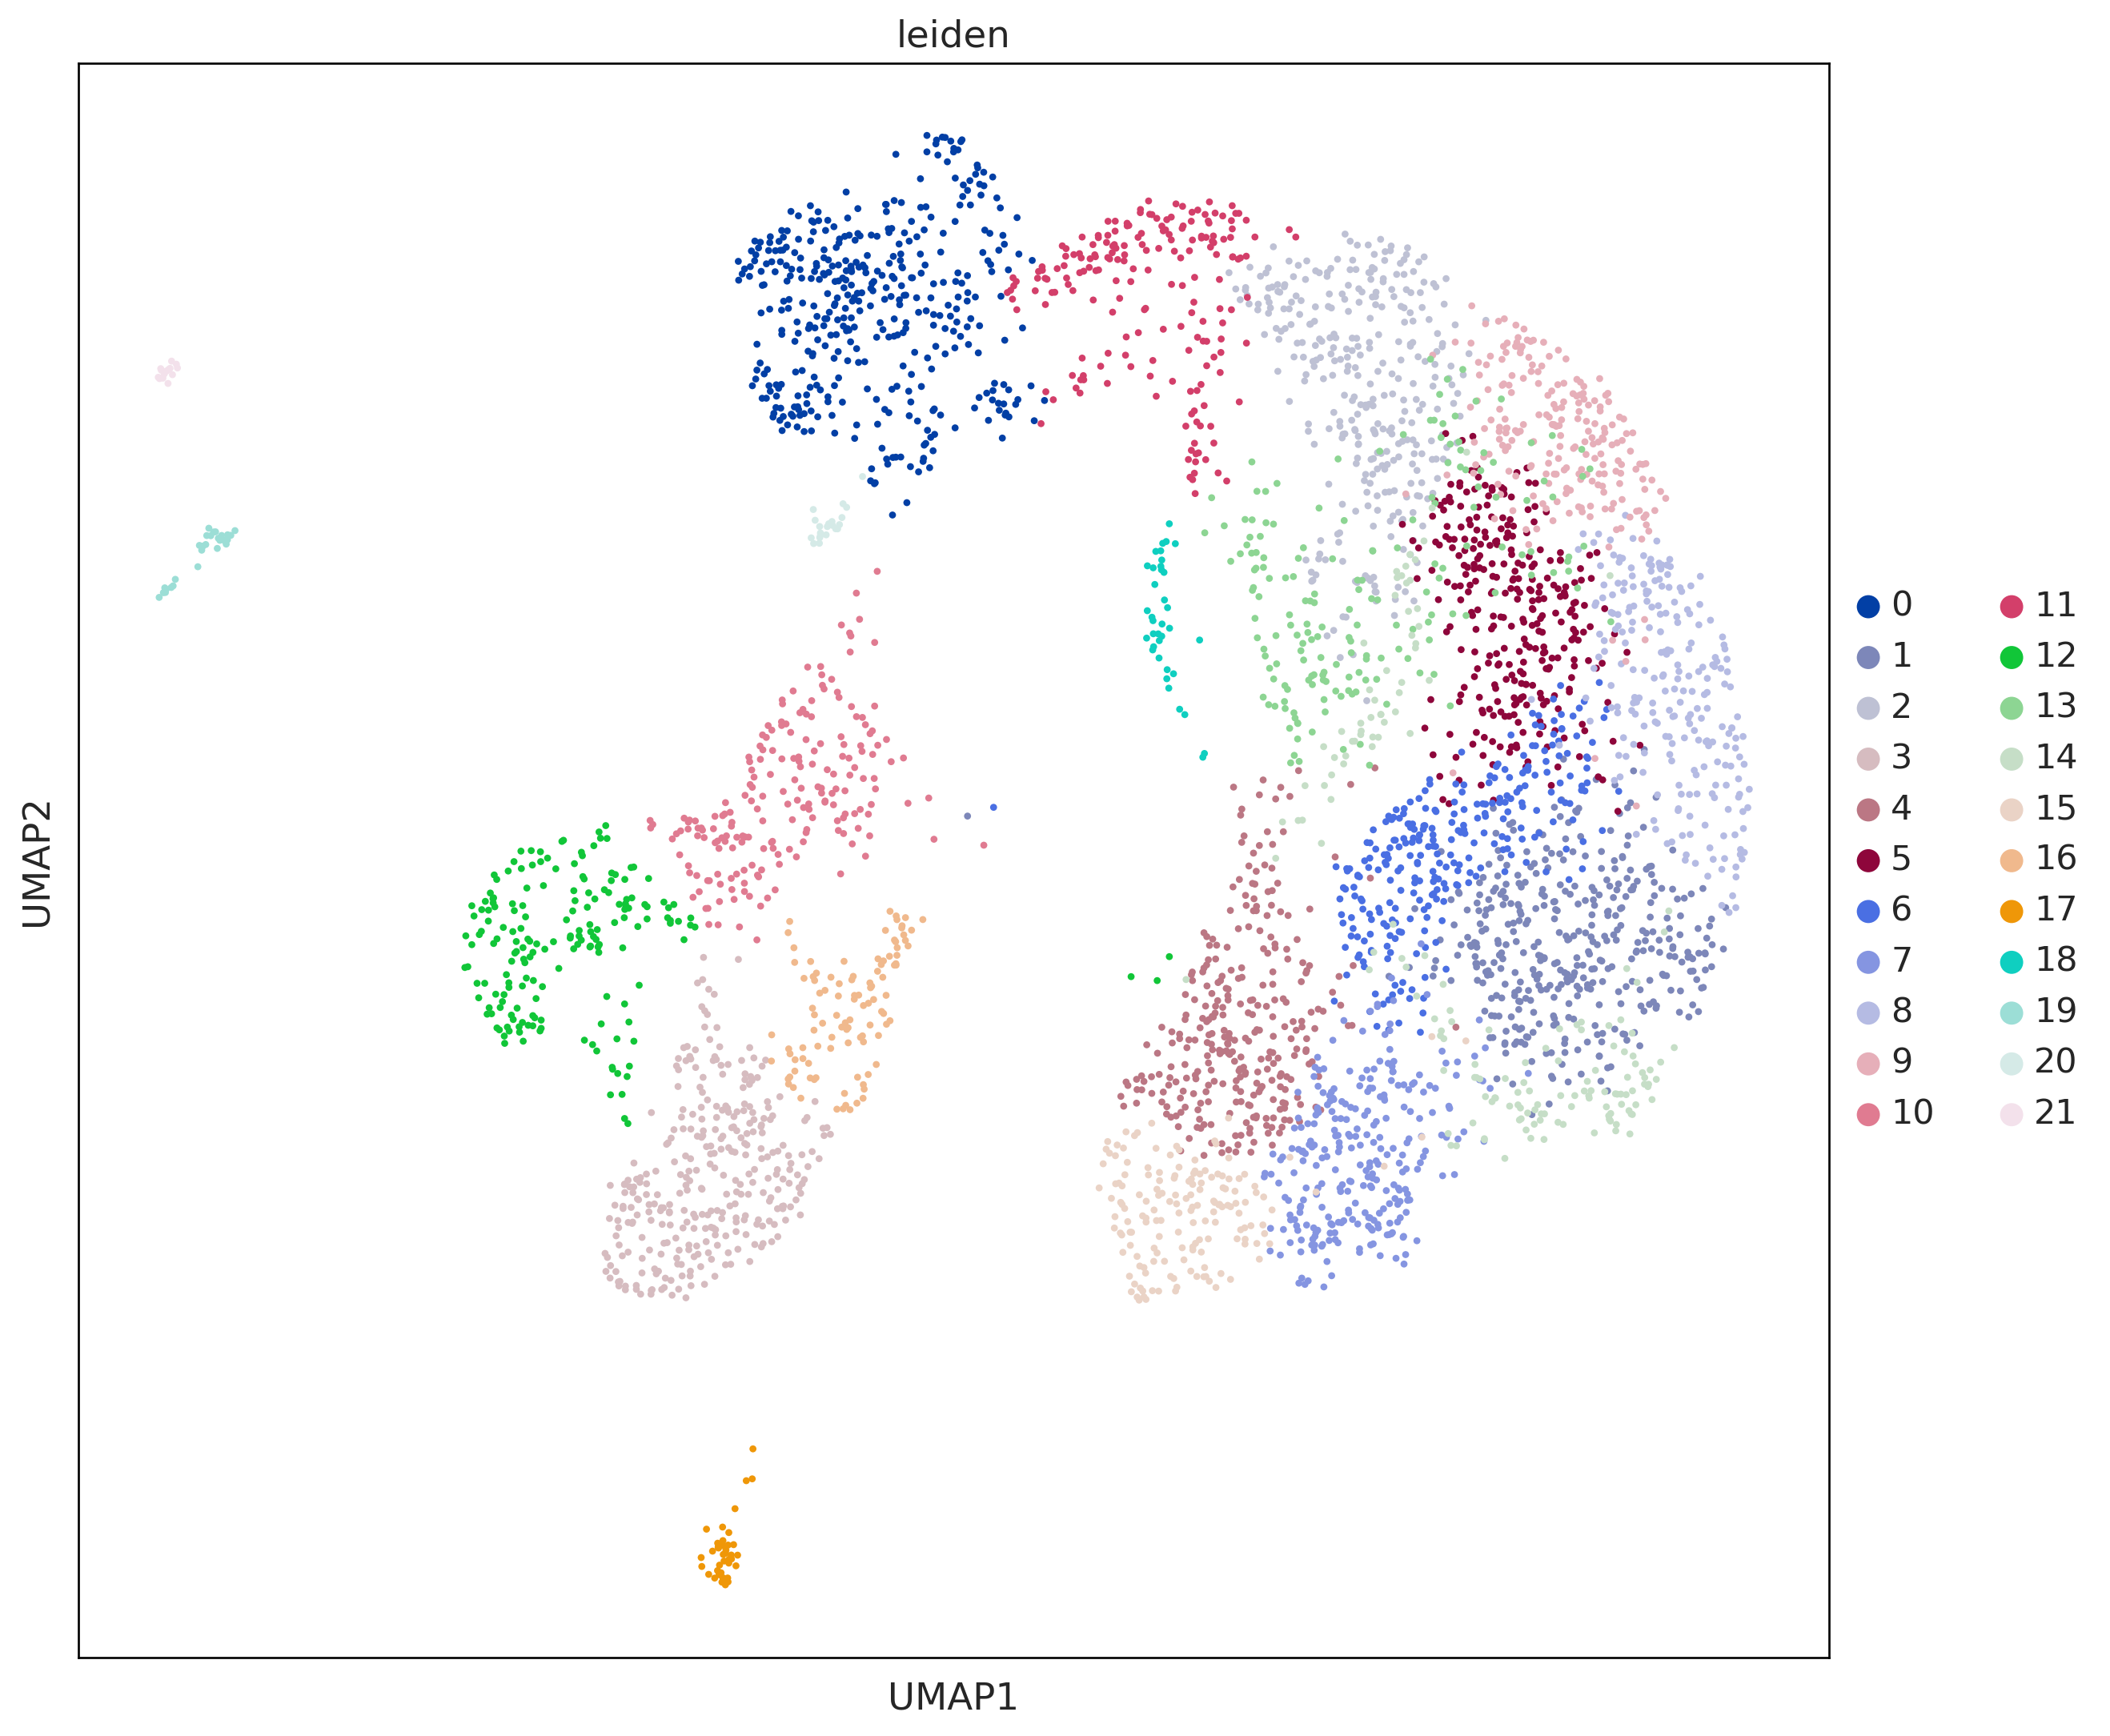

In [139]:
sc.pl.scatter(ad, basis='umap', color=['leiden'])

In [140]:
ad.obs_names = [bc.split('#')[1] for bc in ad.obs_names]

In [143]:
ad.write('../data/atac-multiome10x-mouse.h5ad')

# RNA Preprocessing from 10x output

In [ ]:
rna = sc.read_10x_h5('../data/multiome10x/mouse-brain/e18_mouse_brain_fresh_5k_filtered_feature_bc_matrix.h5')

In [ ]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_rna = sc.AnnData(rna.X)
raw_rna.obs_names, raw_rna.var_names = rna.obs_names, rna.var_names
rna.raw = raw_rna

# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, n_top_genes=1500)
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(rna, n_comps=50, use_highly_variable=True)

In [ ]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=40)
sc.tl.umap(rna)
sc.tl.leiden(rna)

In [ ]:
sc.pl.scatter(rna, basis='umap',color='leiden')

In [ ]:
rna.write('../data/rna-multiome10x-mouse.h5ad')

# Joint analysis of RNA & ATAC

### Possible to download these files or run the above pipeline

In [ ]:
# valid_bcodes = []
# for clst in range(len(np.unique(rna.obs.leiden))):
#     clst = str(clst)
    
#     idxs = rna[rna.obs.leiden== clst].obs.index
#     top_c = atac[idxs].obs.leiden.value_counts().index[0]
    
#     idxs2 = atac[atac.obs.leiden== top_c].obs.index
#     top_c2 = rna[idxs2].obs.leiden.value_counts().index[0]
    
    
#     if clst == top_c2:
#         top_n = atac[idxs].obs.leiden.value_counts()[0]
#         all_n = len(np.union1d(idxs,idxs2))
        
#         if (top_n/all_n) > 0.5:
#             print('RNA cluster '+ clst +' top agreement {:.1%} with ATAC cluster '.format(top_n/all_n) + top_c)
#             valid_bcodes.append(np.intersect1d(idxs,idxs2))
# valid_bcodes = [item for sublist in valid_bcodes for item in sublist]

In [54]:
# intersect_df = pd.DataFrame()
# for clst_rna in range(len(np.unique(rna.obs.leiden))):
#     clst_intersect = []
#     subset_rna = rna[rna.obs.leiden == str(clst_rna)].obs.index
#     for clst_atac in range(len(np.unique(atac.obs.leiden))):
#         subset_atac = atac[atac.obs.leiden == str(clst_atac)].obs.index
#         clst_intersect.append(len(np.intersect1d(subset_rna,subset_atac)))
#     intersect_df = pd.concat([intersect_df,pd.DataFrame({clst_rna: clst_intersect})],axis=1)